In [60]:
import numpy as np
import cmath
import math
import warnings
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import sounddevice as sd

In [97]:
class recordsound():
    """
    recordsound Record your voice for T time sampled at a frequency fs
    solve() generates a sampled signal of your voice and save it into a wav file
    """
    def __init__(self, T, fs):
        """
        :param T: the duration time
        :param fs: the sampling frequency
        """
        self.T = T
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        print('start recording')
        voicerecording = sd.rec(int(self.T * self.fs), self.fs, 1)
        sd.wait()  # Wait until recording is finished
        print('end recording')
        write('myvoice.wav', self.fs, voicerecording)  # Save as WAV file 
        
        return voicerecording

class idft():
    """
    idft Inverse Discrete Fourier transform.
    """
    def __init__(self, X, fs, N, K=None):
        """
        :param X: Input DFT X
        :param fs: Input integer fs contains the sample frequency
        :param N: The number of total signal samples N
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the iDFT.
        """
        self.X=X
        self.fs=fs
        self.N=N 
        self.K=K
        if self.K==None:
            self.K=int(len(X)/2)-1

    def solve_K(self):
        """
        \\\\\ METHOD: Compute the iDFT with truncated K coefficients (Due to computation complexity, we will not use it in Section 2)
        :return iDFT x of duration N from partial DFT X, i.e., X[0], ..., X[K] with K < N/2
        :Treal the realt time vector of size N
        """
        x=np.zeros(self.N)
        
        for n in range(self.N):
            x[n] = 1/np.sqrt(self.N)*self.X[0]*np.exp(1j*2*cmath.pi*0*n/self.N)
            for k in range(1,self.K+1): 
                x[n] = x[n] + 1/np.sqrt(self.N)*self.X[k]*np.exp(1j*2*cmath.pi*k*n/self.N)
                x[n] = x[n] + 1/np.sqrt(self.N)*np.conj(self.X[k])*np.exp(-1j*2*cmath.pi*k*n/self.N)
                
        Ts= 1/self.fs
        Treal= np.arange(self.N)*Ts

        return x, Treal
    
    def solve_ifft(self):
        """
        \\\\\ METHOD: Compute the iDFT with provided function np.fft.ifft (Computationally efficient)
        :Treal the realt time vector of size N
        """
        x=np.fft.ifft(self.X,self.N)*np.sqrt(self.N)
                
        Ts= 1/self.fs
        Treal= np.arange(self.N)*Ts

        return x, Treal   
    
class tripulse():
    """
    sqpulse Generates a triangular spulse
    solve() generates a triangular pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the triangular pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(int(M/2)):
            x[i] = i
            x[M-i-1] = i

        energy = np.linalg.norm(x)
            
        for i in range(M):
            x[i] = x[i]/energy  
        
        return x, N

class sqpulse():
    """
    sqpulse Generates a square spulse
    solve() generates a square pulse vector x of length N
    """
    def __init__(self, T, T0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.T0 = T0
        self.fs = fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the square pulse vector x
        :N: The sample duration
        """
        Ts = 1/self.fs
        N = math.floor(self.T/Ts)
        M = math.floor(self.T0/Ts)
        x = np.zeros(N)
        
        for i in range(M):
            x[i] = 1/np.sqrt(M)
        
        return x, N
    
class dft():
    
    def __init__(self, x, fs, K=None):
        """
        :param x: Input vector x contains the discrete signal
        :param fs: Input integer fs contains the sample frequency
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. If K is not provided, K=length(x).
        """
    # START: SANITY CHECK OF INPUTS.
        if (type(fs) != int) or (fs<=0):
            raise NameError('The frequency fs should be a positive integer.')
        if not isinstance(x, np. ndarray):
            raise NameError('The input signal x must be a numpy array.')
        if isinstance(x, np. ndarray):
            if x.ndim!=1:
                raise NameError('The input signal x must be a numpy vector array.')
        self.x=x
        self.fs=fs
        self.N=len(x)
        if K == None:
            K = len(self.x)
        # START: SANITY CHECK OF INPUTS.
        if (type(K) != int) or (K <= 0) or (K < 0):
            raise NameError('K should be a positive integer.')
        self.K=K
        self.f=np.arange(self.N)*self.fs/self.N # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(self.N/2)+1,np.floor(self.N/2)+1)*self.fs/self.N
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.
    def changeK(self,K):
        """
        :param K: Input positive integer that determines the number of coeffients
        used to calculate the DFT. This function changes the attribute K of the class.
        """
        if (type(K) != int) or (K <= 0) or (K <  0):
                raise NameError('K should be a positive integer.')
        old_K=self.K
        self.K=K
        self.f=np.arange(self.K)*self.fs/self.K # (0:K-1) just creates a vector from 0 to K by steps of 1.
        self.f_c=np.arange(-np.ceil(K/2)+1,np.floor(self.K/2)+1)*self.fs/self.K
        # This accounts for the frequencies
        # centered at zero. I want to be guaranteed that k=0 is always a
        # possible k. Then, I also have to account for both even and odd choices
        # of K, and that's why the floor() function appears to round down the
        # numbers.
        print('The value of K was succefully change from %d to %d'%(old_K,self.K))
        pass
    def solve3(self):
            X=np.fft.fft(self.x,self.N)/np.sqrt(self.N);
            # \\\\\ CENTER FFT.
            X_c=np.roll(X,int(np.ceil(self.N/2-1))) # Circularly shift X to get it centered in f_c==0
            return [self.f,X,self.f_c,X_c]
class sqwave():
    """
    sqpulse Generates a square spulse
    solve() generates a square pulse vector x of length N
    """
    def __init__(self, T, f0, fs):
        """
        :param T: the duration
        :param T0: nonzero length
        :param fs: the sampling frequency
        """
        self.T = T
        self.f0 = f0
        self.fs = fs
        self.N = T*fs
                
    def solve(self):
        """
        :return: [x,N]
        :x: the square pulse vector x
        :N: The sample duration
        """
        n = np.arange(self.N)
        x = np.sign(np.cos(2*cmath.pi*self.f0/self.fs*n))
        
        return x, self.N


In [81]:
#Problem 1.1
class idft_q11():
    
    def __init__(self, X, fs):
        
        self.X=X
        self.N=(len(X)-1)*2
        self.fs=fs

    def solve(self):

        x=np.zeros(self.N)
    
        for n in range(self.N):
            x[n] = 1/np.sqrt(self.N)*X[0]*np.exp(j*2*cmath.pi*0*n/self.N)
            for k in range(1,int(self.N/2)): 
                x[n] = x[n] + 1/np.sqrt(self.N)*X[k]*np.exp(j*2*cmath.pi*k*n/self.N)
                x[n] = x[n] + 1/np.sqrt(self.N)*np.conj(X[k])*np.exp(-j*2*cmath.pi*k*n/self.N)
            x[n] = x[n] + 1/np.sqrt(self.N)*self.X[int(self.N/2)]*np.exp(j*2*cmath.pi*(int(self.N/2))*n/self.N)
                
        Ts= 1/self.fs
        Treal= np.arange(self.N)*Ts

        return x, Treal

In [87]:
#Problem 1.2
class Signal_Reconstruction():

    def __init__(self, X_k, fk):

        self.X=X_k
        self.fk=fk
        self.N=len(fk)
        self.K=self.X.shape[0]

    def solve(self):
        
        x=np.zeros(self.N)
        
        for n in range(self.N):
            for k in range(self.K):
                x[n] = x[n]+1/np.sqrt(self.N)*self.X[k,0]*np.exp(1j*2*cmath.pi*self.X[k,1]*n/self.N)
            
        return x

In [67]:
def q_13(T, fs, T0, K):
    
    sp = sqpulse(T, T0, fs) 
    x, N = sp.solve()
    DFT = dft(x,fs)    
    [f,X,f_c,X_c] = DFT.solve3()    

    iDFT = idft(X, fs, N, K)    
    xhat_K, Treal = iDFT.solve_K()
    
    x_diff = x - xhat_K  
    energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)   
    print(energy_diff)
    
    warnings.filterwarnings("ignore")
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, abs(X_c))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()    
    
    plt.figure()
    plt.grid(True)
    plt.title('Reconstructed Signal K=' + str(K)+','+ 'T0=' + str(T0))
    plt.plot(Treal, xhat_K)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.show()

C:\Users\Mosta\AppData\Local\Temp/ipykernel_11500/462267365.py:58: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = 1/np.sqrt(self.N)*self.X[0]*np.exp(1j*2*cmath.pi*0*n/self.N)
C:\Users\Mosta\AppData\Local\Temp/ipykernel_11500/462267365.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = x[n] + 1/np.sqrt(self.N)*self.X[k]*np.exp(1j*2*cmath.pi*k*n/self.N)
C:\Users\Mosta\AppData\Local\Temp/ipykernel_11500/462267365.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  x[n] = x[n] + 1/np.sqrt(self.N)*np.conj(self.X[k])*np.exp(-1j*2*cmath.pi*k*n/self.N)


0.43489471860590406


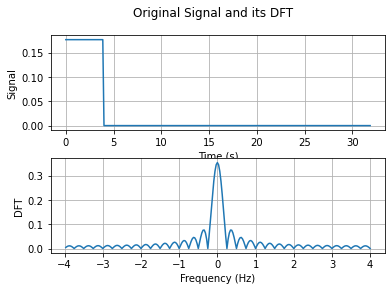

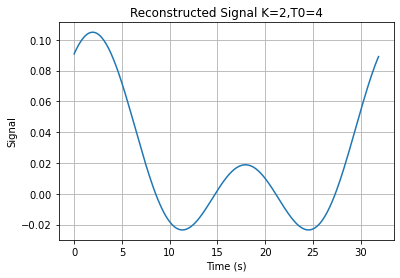

0.17967500795890437


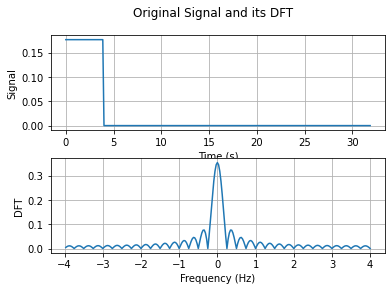

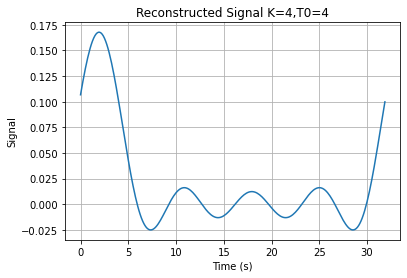

0.09684275127814174


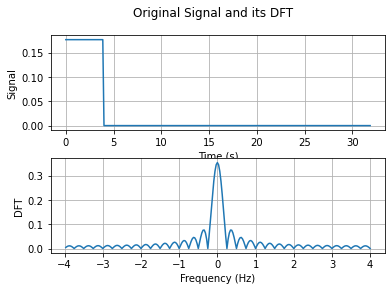

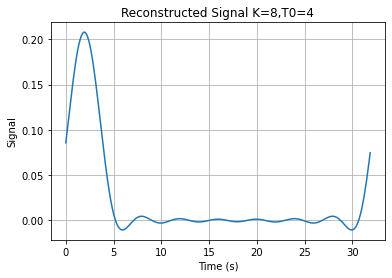

0.04940696479139808


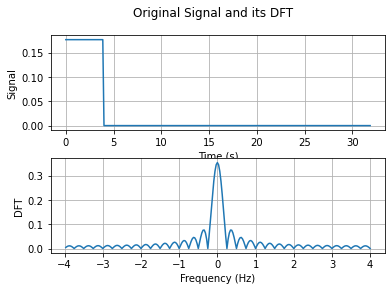

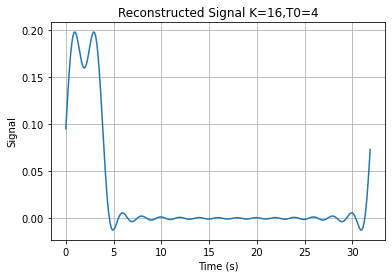

0.0239358838840452


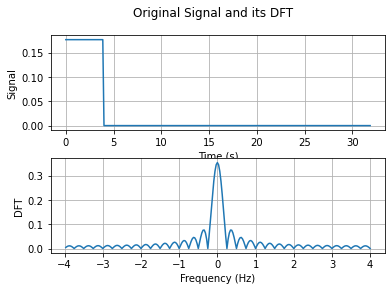

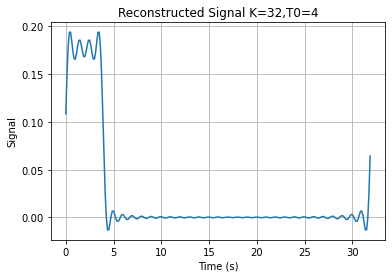

0.6953629622409722


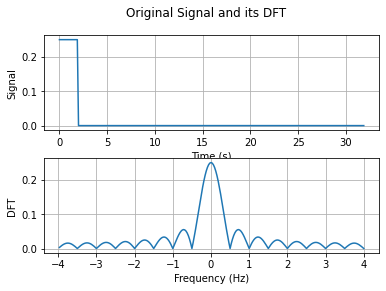

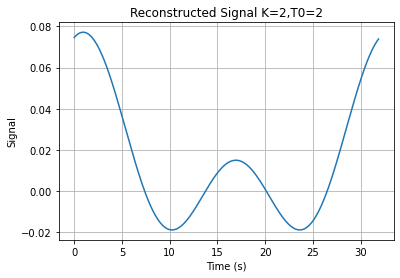

0.4827150054031634


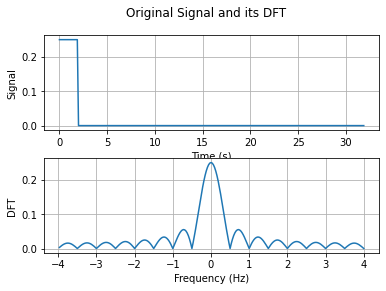

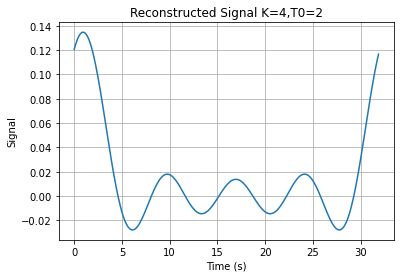

0.2012976362385335


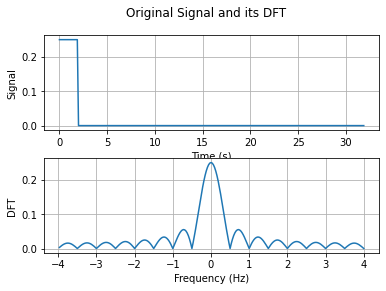

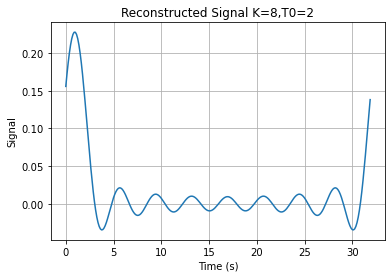

0.09587122825996373


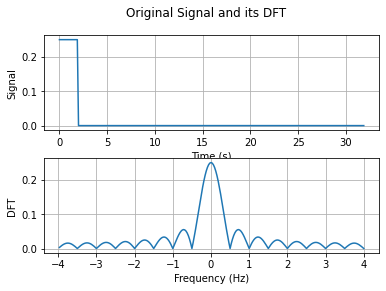

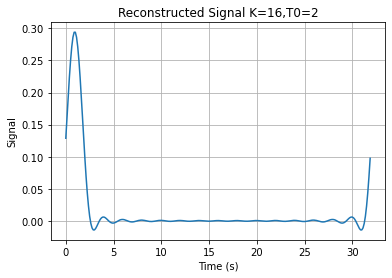

0.04743032398620466


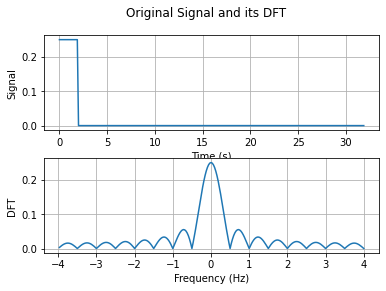

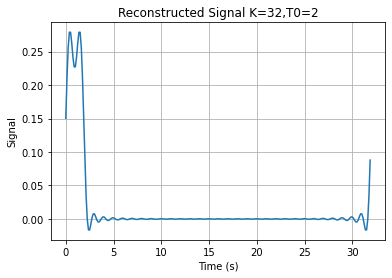

In [68]:
#Problem 1.3
K=2
while K <= 32:
    q_13(32, 8, 4, K)
    K = 2*K
K=2
while K <= 32:
    q_13(32, 8, 2, K)
    K = 2*K

We can see from the first four graphs, that as we increase the value of K, we get a much more accurate reconstructed signal. K = 32 is a very close approximation of the signal that gives almost the same information as our original signal. The drawback to this is of course more computation, which can really be a negative when many more signals than just a square pulse needs to be processed.

We also see that as we decrease T0, the reconstructed signal is also more accurate, with  K = 32, having a virtually horizontal line between time = 10s and 25s (which is honestly pretty crazy, because we are nearly recreating a straight line with oscillations)!

In [84]:
def q_14(T, fs, T0, K):
    
    tp = tripulse(T, T0, fs)    
    x, N = tp.solve()
    DFT = dft(x,fs)
    [f,X,f_c,X_c] = DFT.solve3()    

    iDFT = idft(X, fs, N, K)
    xhat_K, Treal = iDFT.solve_K()
    
    x_diff = x - xhat_K
    energy_diff = np.linalg.norm(x_diff)*np.linalg.norm(x_diff)
    print(energy_diff)
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, abs(X_c))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show() 
    
    plt.figure()
    plt.grid(True)
    plt.title('Reconstructed Signal ' 'K=' + str(K)+','+ 'T0=' + str(T0))
    plt.plot(Treal, xhat_K)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.show()

0.567404479014087


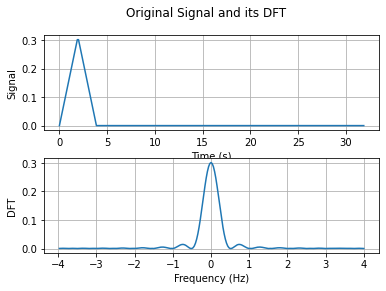

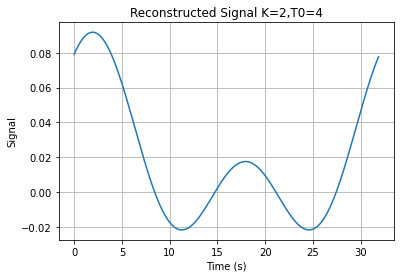

0.29907111737613046


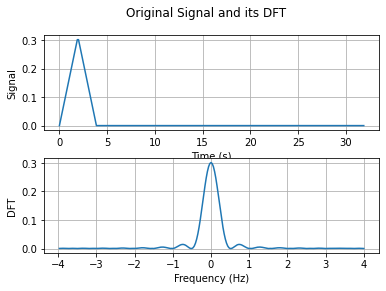

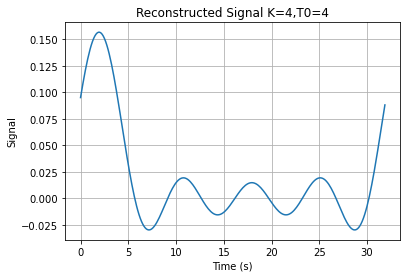

0.042878108770746194


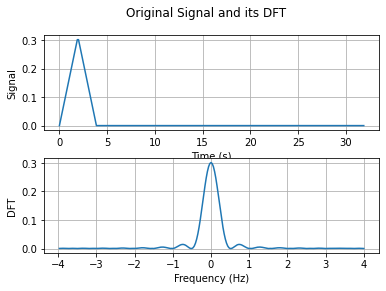

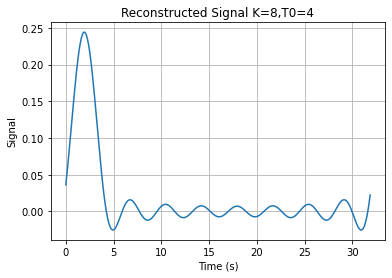

0.0029442156772182424


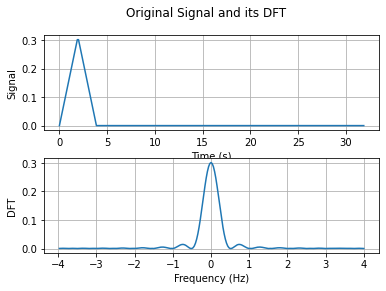

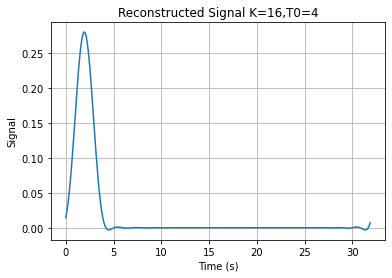

0.0004416329933486629


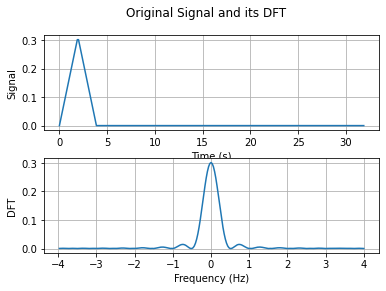

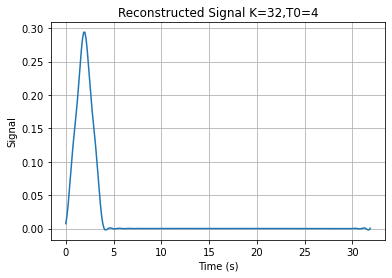

In [86]:
K=2
while K <= 32:
    q_14(32, 8, 4, K)
    K = 2*K

A triangle pulse should be easier to reconstruct than a square pulse, because a triangle pulse is a lower frequency overall. Triangle pulses change less rapidly than square pulses, as square pulses have a very steep dropoff, whereas a triangle pulse has a comparatively gradual decline. It is easier to reconstruct a slowly changing signal than it is to reconstruct one of high frequency, thus the triangle pulse should be easier to reconstruct.

In [101]:
#Problem 1.6
class dft_K_q16():

    def __init__(self, x, fs, K):
        
        self.x=x
        self.fs=fs
        self.N=len(self.x)
        self.K=K

    def solve(self):
        
        X=np.zeros(self.N, dtype=np.complex)
        E=np.zeros(self.N)
        X_K=np.zeros(self.K, dtype=np.complex)
        index=np.zeros(self.K)
        
        for k in range(self.N):
            for n in range(self.N):
                X[k] = X[k]+1/np.sqrt(self.N)*self.x[n]*np.exp(-1j*2*cmath.pi*k*n/self.N)
        fk= np.arange(self.N)/self.N*self.fs
                
        for k in range(self.N):
            E[k]=abs(X[k])
        index_temp=np.argsort(-E)        
        index=index_temp[0:self.K]
        index = index[:,np.newaxis]
        X_K=X[index]
        X_K=np.concatenate((X_K,index),axis=1)
            
        return X_K, fk

In [102]:
#Problem 1.8
def q_18(T, fs, T0, K):
    sp = sqpulse(T, T0, fs)    
    x, N = sp.solve()
    DFT_K = dft_K_q16(x,fs,K)
    X_K, fk = DFT_K.solve()
    
    iDFT = Signal_Reconstruction(X_K, fk)
    xhat_K = iDFT.solve()
    
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time(s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time(s)')
    axs[1].set_ylabel('Signal')
    plt.show() 

In [108]:
def q_19(T, fs, f0, K):
    
    sp = sqwave(T, f0, fs)    
    x, N = sp.solve()
    DFT = dft(x,fs)
    [f,X,f_c,X_c] = DFT.solve3()      
    
    DFT_K = dft_K_q16(x,fs,K)
    X_K, fk = DFT_K.solve()
    
    iDFT = Signal_Reconstruction(X_K, fk)
    xhat_K = iDFT.solve()
    
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, abs(X_c))
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()
    plt.figure()
    plt.grid(True)
    plt.title('Reconstructed Signal K='+ str(K))
    plt.plot(Treal, xhat_K)
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.show()

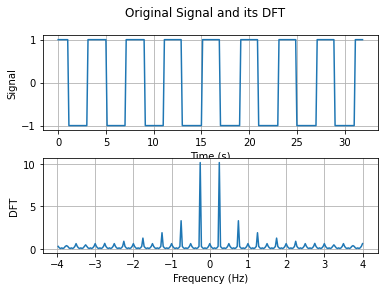

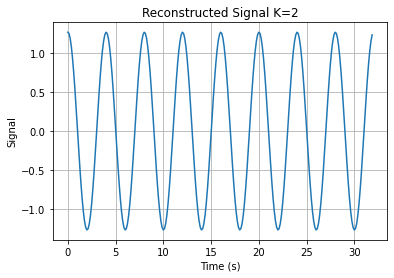

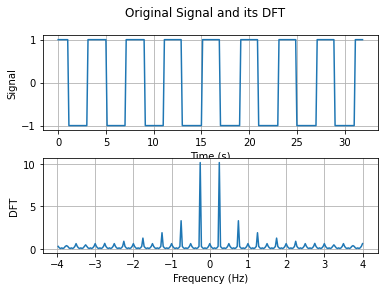

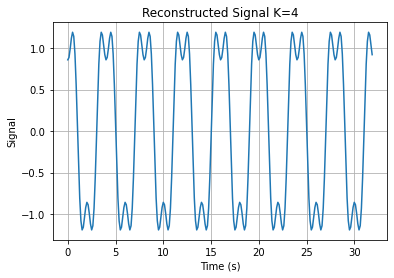

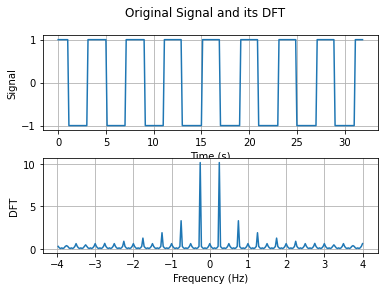

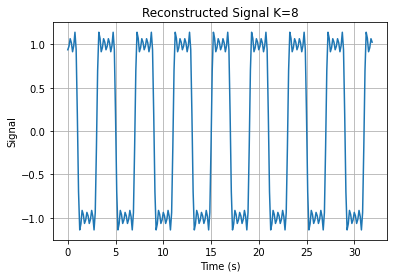

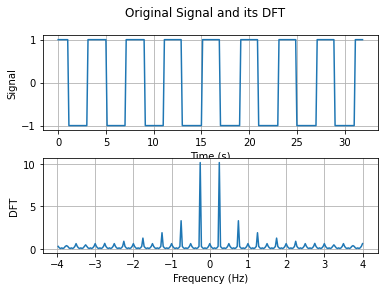

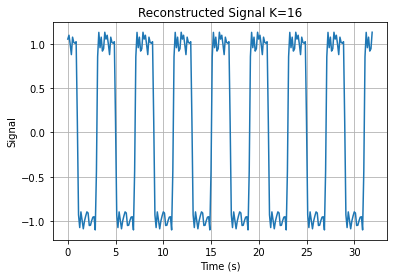

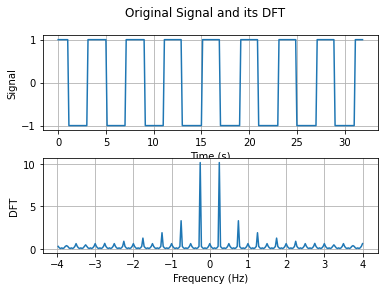

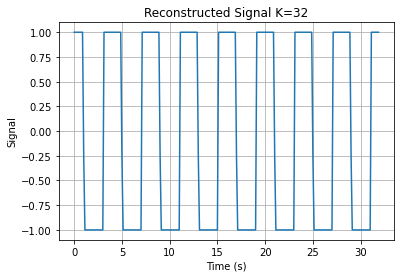

In [109]:
#Problem 1.9
K=2
while K <= 32:
    q_19(32, 8, .25, K)
    K = 2*K

I don't understand what this one means guys, so come save me lol

In [113]:
def q_21(T, fs):

    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    Ts= 1/fs
    Treal= np.arange(N)*Ts
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and its DFT' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time(s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(f_c, X_c)
    axs[1].set_xlabel('Frequency (Hz)')
    axs[1].set_ylabel('DFT')
    plt.show()     

start recording
end recording


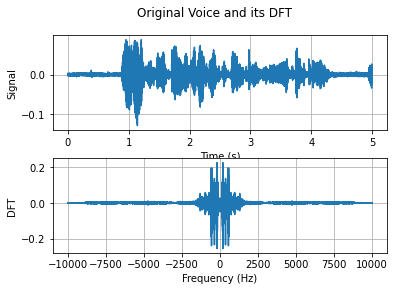

In [115]:
#Problem 2.1
q_21(5,20000)

This DFT make a lot of sense for a voice, as my voice (or anyone's for that matter) generally stays around the same range of frequencies during normal speech. Most people don't go from very high pitched to very low pitched during a normal sentence.

In [125]:
def q_22_1(T, fs, gamma):

    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    truncated_sample = int(N*gamma)
    X_truncated = np.zeros(N, dtype=np.complex)
    X_truncated[0:truncated_sample] = X[0:truncated_sample]
    
    iDFT = idft(X_truncated, fs, N)
    xhat_K, Treal = iDFT.solve_ifft()
    
    write('myvoice_truncated1.wav', fs, xhat_K.real)
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and Reconstructed Voice' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show()     
    
def q_22_2(T, fs, gamma):
    
    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.solve3()
    
    truncated_sample = int(N*gamma/2)
    X_truncated = np.zeros(N, dtype=np.complex)
    E=np.zeros(N)
    for k in range(N):
        E[k]=abs(X[k])
    index_temp=np.argsort(-E)
    index=index_temp[0:truncated_sample]
    X_truncated[index]=X[index]
    
    iDFT = idft(X_truncated, fs, N)
    xhat_K, Treal = iDFT.solve_ifft()
    
    write('myvoice_truncated2.wav', fs, xhat_K.real)

    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Voice and Reconstructed Voice' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show()     
    

start recording
end recording


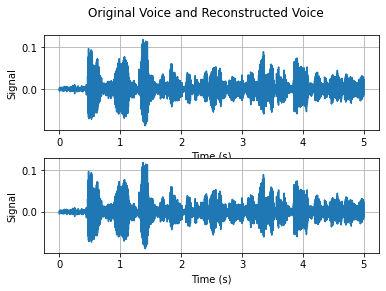

In [122]:
q_22_1(5, 20000, 8)

start recording
end recording


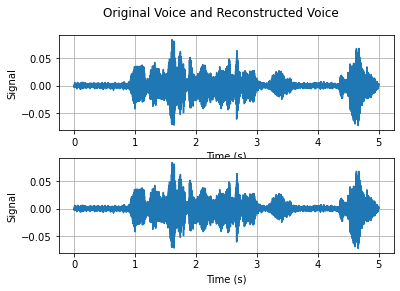

In [126]:
q_22_2(5, 20000, 8)

In [128]:
#Problem 2.3
def q_23(T, fs, threshold):

    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)

    DFT = dft(x,fs)
    [freqs, X, f_c, X_c] = DFT.solve3()    
    
    for k in range(N):
        E=abs(X[k])
        if E > threshold:
            X[k] = 0
    
    iDFT = idft(X, fs, N)
    xhat_K, Treal = iDFT.solve_ifft()
    
    write('myvoice_truncated3.wav', fs, xhat_K.real)
    
    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, xhat_K)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 
    

start recording
end recording


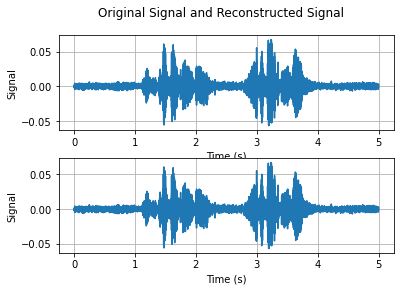

In [129]:
 q_23(5, 20000, .3)

In [130]:
#Problem 2.4
def q_24(T, fs, gamma):
    """
    Question 2.4
    
    """
    
    myvoice = recordsound(T, fs)  
    x = myvoice.solve().reshape(T*fs)
    N = len(x)
    chunks = T*10
    chunk_sample = 0.1*fs
    x_recon = []
    
    for i in range(chunks):        
        current_chunk = x[int(i*chunk_sample):int(i*chunk_sample+chunk_sample)]
        n = len(current_chunk)
        DFT_chunk = dft(current_chunk, fs)
        [freqs_chunk, X_chunk, f_c_chunk, X_c_chunk] = DFT_chunk.solve3()
        K = int(n*gamma)
        X_chunk_truncated = np.zeros(n,dtype=np.complex)
        X_chunk_truncated[0:K] = X_chunk[0:K]
        iDFT = idft(X_chunk_truncated, fs, n)
        x_idft, Treal = iDFT.solve_ifft() 
        x_recon = np.concatenate([x_recon, x_idft])
    Ts= 1/fs
    Treal= np.arange(N)*Ts

    fig, axs = plt.subplots(2)
    axs[0].grid()
    axs[1].grid()
    fig.suptitle('Original Signal and Reconstructed Signal' )
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    axs[0].plot(Treal, x)
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Signal')
    axs[1].plot(Treal, x_recon)
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Signal')
    plt.show() 


start recording
end recording


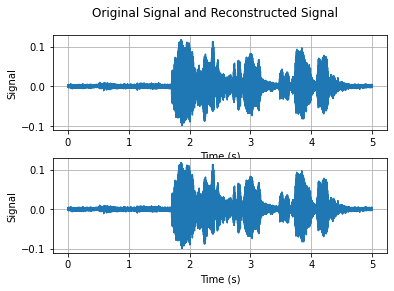

In [132]:
q_24(5, 20000, 4)